In [13]:
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import ast
import pathlib
import os
import ujson as json
from sklearn.metrics import accuracy_score, average_precision_score, recall_score, confusion_matrix
from IPython import display
from diagrams import Diagram, Node, Edge, Cluster
from diagrams.aws.compute import EC2
from diagrams.aws.database import RDS
from diagrams.aws.network import ELB
from collections import Counter
from dataclasses import dataclass
from pickle import TRUE
from pprint import pprint
from typing import Any, List
from matplotlib import pyplot
import pytorch_lightning as pl
import torch.nn.functional as F
import torch
import albumentations as A

from torch.utils.data import DataLoader2
from torchvision.transforms import transforms
from loguru import logger
from torchvision.datasets import ImageFolder
from torch.cuda.amp.autocast_mode import autocast

import os
import ujson as json
from tqdm import tqdm
import numpy as np
import copy
from pytorch_lightning.loggers import MLFlowLogger
from ClassifierDataset import MultilabelDataset
from TrainClassifierParams import trainParams
from pytorch_lightning.callbacks import ModelCheckpoint

from data import ImportEnv
from loguru import logger as displayLogger
from mlflow.tracking.client import MlflowClient
import itertools
import warnings
import torchvision
import torchmetrics
import dataclasses
import shutil
from torchmetrics.classification.accuracy import MultilabelAccuracy
from torchmetrics import Precision, Recall

from torchmetrics.classification.confusion_matrix import (
    ConfusionMatrix,
    MultilabelConfusionMatrix,
)
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import pandas as pd
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import glob
from cleanlab.classification import CleanLearning
import pathlib
from LocalPipeline import getAllParts
import mlflow
from sklearn.metrics import accuracy_score
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.model_selection import (
    iterative_train_test_split,
    label_combination_distribution,
    
)
from skmultilearn.model_selection.iterative_stratification import (
    IterativeStratification
)
from MultilabelKFold import GetDataDir, getAllPart
import plotly.express as px
import plotly.graph_objects as go
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [14]:
allPerfDf = pd.read_csv("/home/alextay96/Desktop/new_workspace/DLDataPipeline/tmp/models_43_perf.csv")
allPerfDf = allPerfDf.round(decimals=2)


In [15]:
def genAgg(evalDf, colName, metric):
    avgAcc = evalDf.groupby(["part"])[colName].mean().reset_index()
    minAcc = evalDf.groupby(["part"])[colName].min().reset_index().rename(columns={colName : f"min_{metric}"})
    maxAcc = evalDf.groupby(["part"])[colName].max().reset_index().rename(columns={colName : f"max_{metric}"})
    # print(colName)
    tempDf = avgAcc.merge(minAcc, on="part")
    tempDf = tempDf.merge(maxAcc, on="part")
    return tempDf

In [16]:
def vis(tempDf1,metricName, metric , viewName):
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=tempDf1["part"], y=tempDf1[metricName],
        text = tempDf1[metricName],

        error_y=dict( 
                    type='data',
                    symmetric=False,
                    array=tempDf1[f"max_{metric}"] - tempDf1[metricName],
                    arrayminus=tempDf1[metricName] - tempDf1[f"min_{metric}"]
    )))
    avgVal = tempDf1[metricName].mean().item()
    fig.add_hline(y=avgVal, line_width=2, line_color="red")
    # print(avgVal)
    fig.update_layout(
        yaxis = dict(
            tickmode = 'array',
            tickvals = [np.format_float_positional(avgVal, 2), 0.2, 0.5],
        )
    )
    fig.update_layout(
        title=go.layout.Title(
            text=f"{viewName}_{metricName}",
            x=0.5
        ))
    return fig

In [17]:
with open("../data/angle.json", "r") as f:
    anglePartMap = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../data/angle.json'

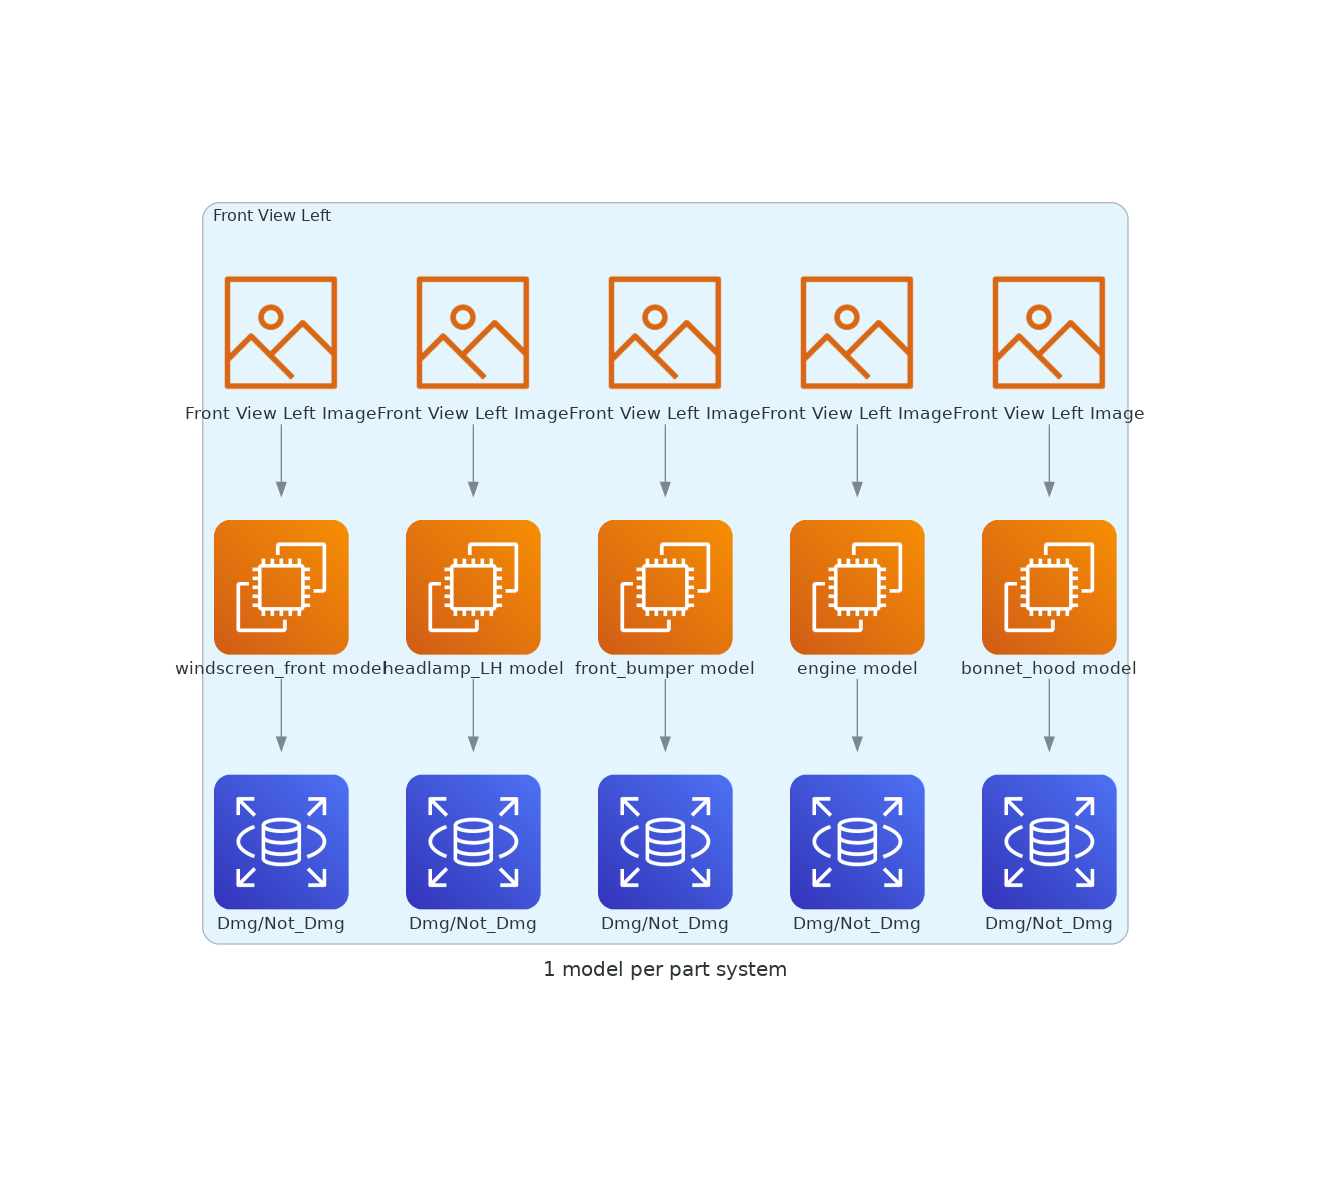

In [ ]:
from diagrams.aws.compute import EC2ContainerRegistryImage
visCount = 0
with Diagram(name="1 model per part system", show=False, direction="TB") as fig:
    # Node("aa") >> Node("nn")
    for view, parts in anglePartMap.items():
        with Cluster(label=view) as c1:
            for part in parts:
                visCount += 1
                if(visCount > 5):
                    break
                EC2ContainerRegistryImage(f"{view} Image") >> EC2(f"{part} model") >> RDS("Dmg/Not_Dmg")
fig

In [ ]:

metricName = "test_acc"
metric = metricName.split("_")[-1]
viewName = "Front View"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

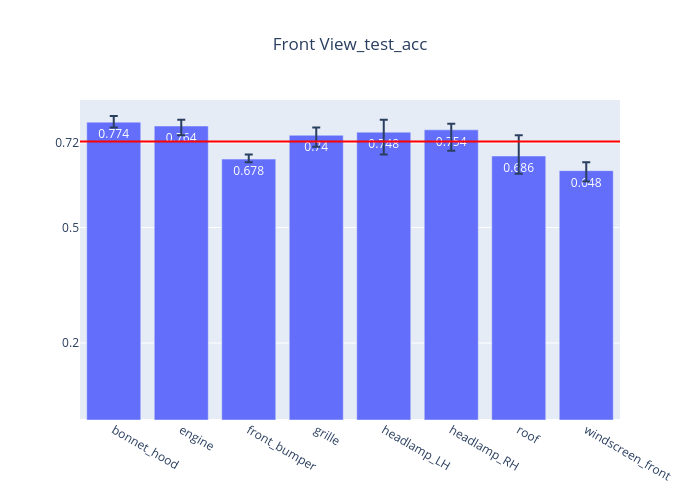

In [ ]:
#| label: Front View Parts Acc
#| fig-cap: "Front View Parts Acc"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_acc"
metric = metricName.split("_")[-1]
viewName = "Front View Left"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

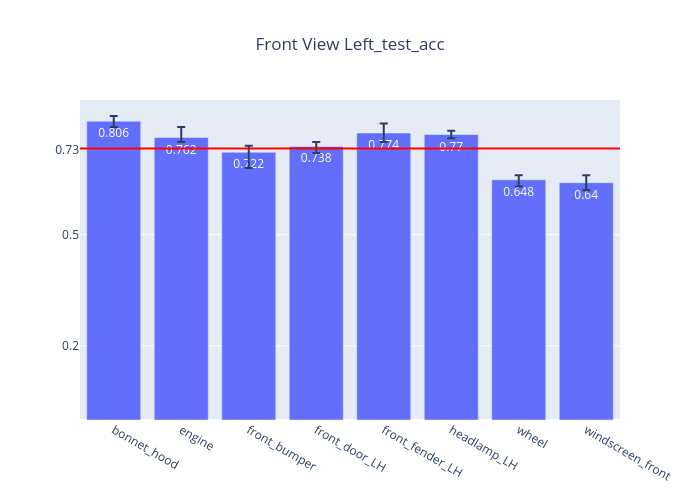

In [ ]:
#| label: Front View Left Parts Acc
#| fig-cap: "Front View Left Parts Acc"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_acc"
metric = metricName.split("_")[-1]
viewName = "Front View Right"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

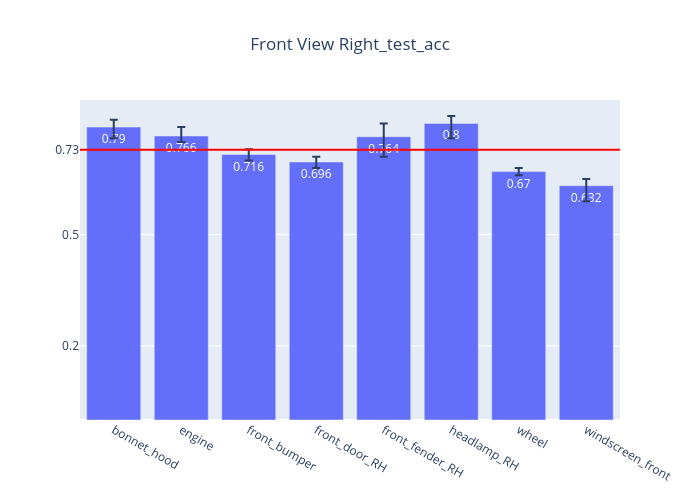

In [ ]:
#| label: Front View Right Parts Acc
#| fig-cap: "Front View Right Parts Acc"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_acc"
metric = metricName.split("_")[-1]
viewName = "Rear View"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

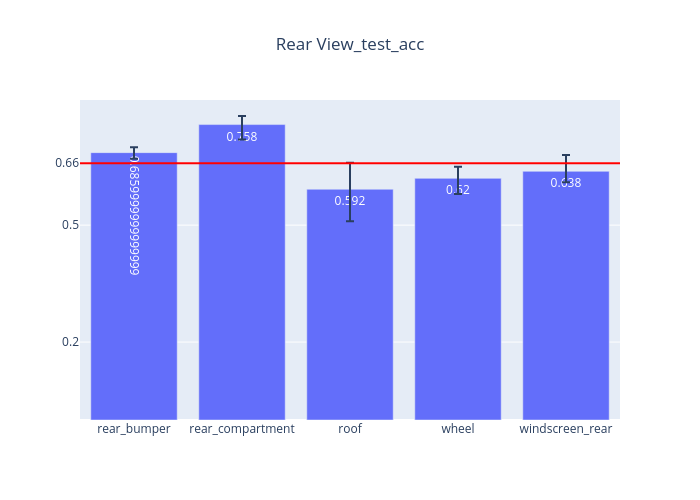

In [ ]:
#| label: Rear View Parts Acc
#| fig-cap: "Rear View Parts Acc"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_acc"
metric = metricName.split("_")[-1]
viewName = "Rear View Left"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

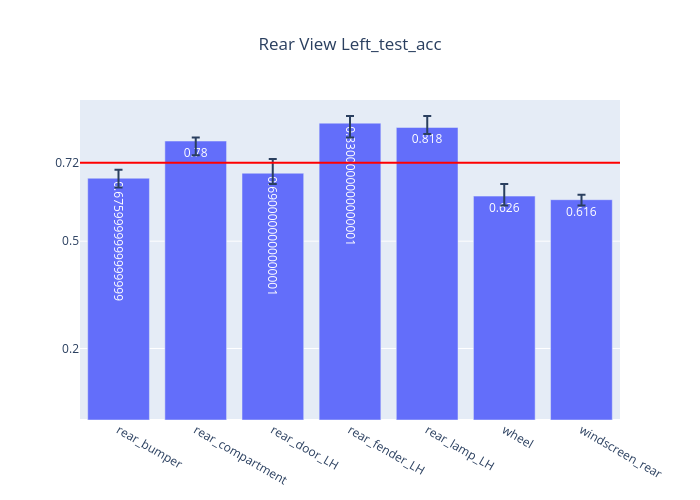

In [ ]:
#| label: Rear View Left Parts Acc
#| fig-cap: "Rear View Left Parts Acc"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_acc"
metric = metricName.split("_")[-1]
viewName = "Rear View Right"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

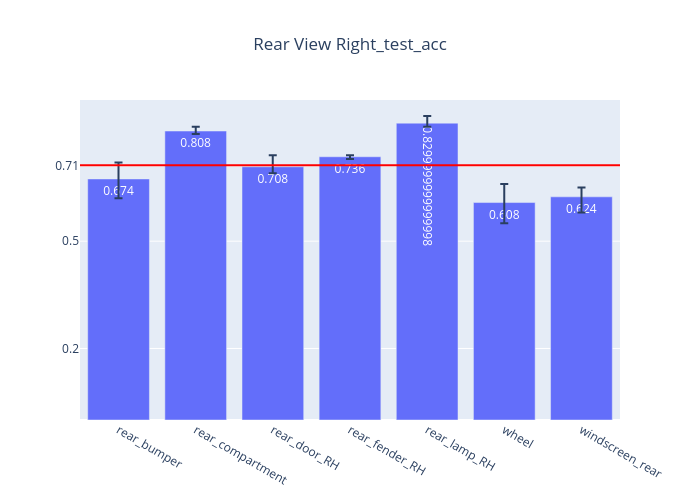

In [ ]:
#| label: Rear View Right Parts Acc
#| fig-cap: "Rear View Right Parts Acc"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_tp"
metric = metricName.split("_")[-1]
viewName = "Front View"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

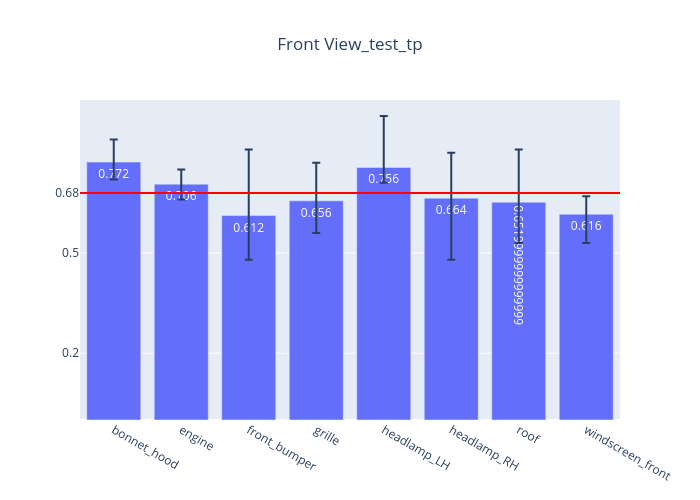

In [ ]:
#| label: Front View TP Acc
#| fig-cap: "Front View Parts TP"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_tp"
metric = metricName.split("_")[-1]
viewName = "Front View Left"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

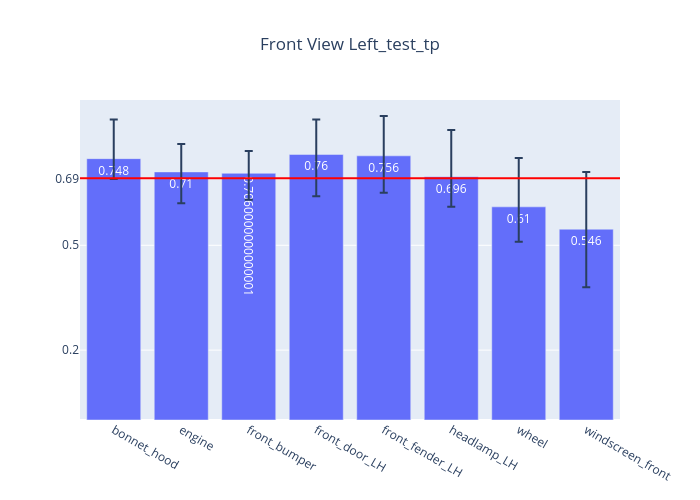

In [ ]:
#| label: Front View Left TP Acc
#| fig-cap: "Front View Left Parts TP"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_tp"
metric = metricName.split("_")[-1]
viewName = "Front View Right"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

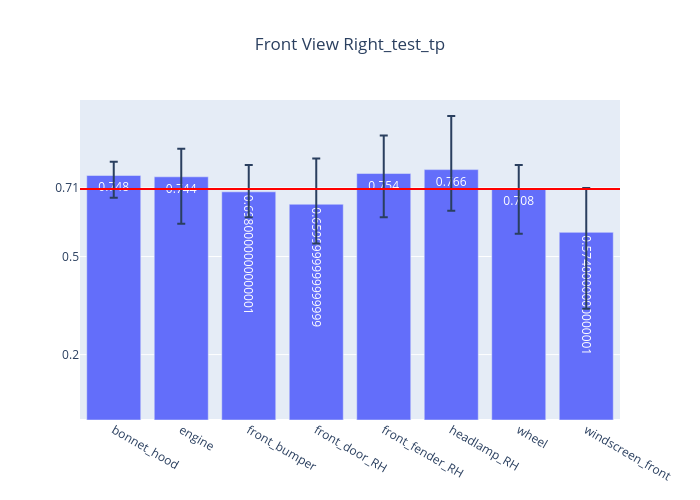

In [ ]:
#| label: Front View Right TP Acc
#| fig-cap: "Front View Right Parts TP"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_tp"
metric = metricName.split("_")[-1]
viewName = "Rear View"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

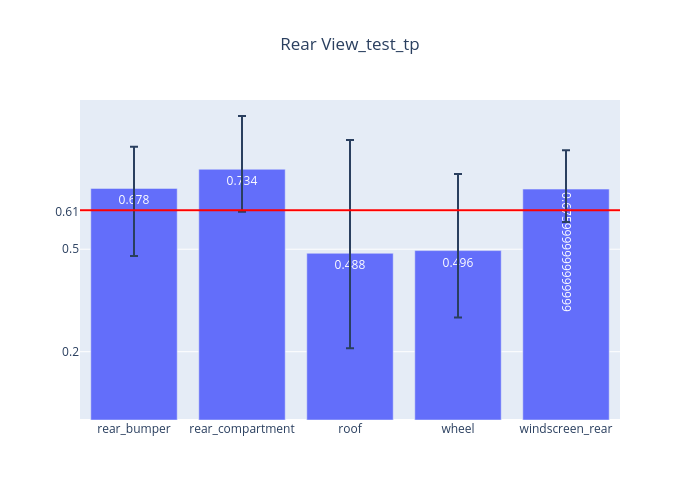

In [ ]:
#| label: Rear View TP Acc
#| fig-cap: "Rear View Parts TP"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_tp"
metric = metricName.split("_")[-1]
viewName = "Rear View Left"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

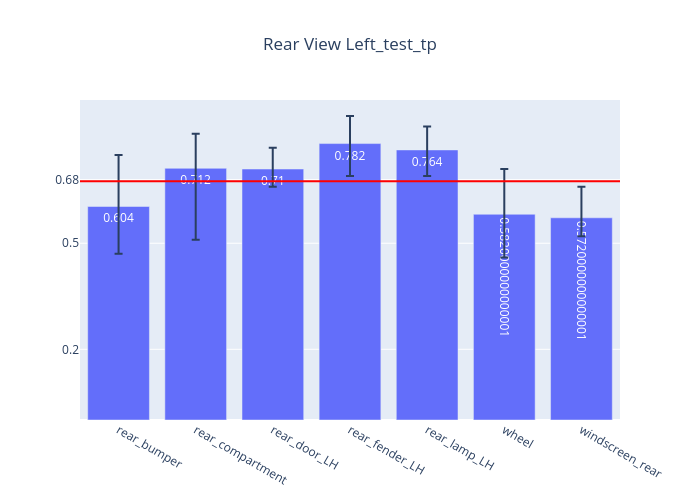

In [ ]:
#| label: Rear View Left TP Acc
#| fig-cap: "Rear View Left Parts TP"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_tp"
metric = metricName.split("_")[-1]
viewName = "Rear View Right"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

In [ ]:
metricName = "test_tp"
metric = metricName.split("_")[-1]
viewName = "Rear View Right"
df = allPerfDf
avgAccByPart = df.groupby(["part"])[metricName].mean().reset_index()
avgAccByPart


part   test_tp
0        bonnet_hood  0.756000
1             engine  0.720000
2       front_bumper  0.672000
3      front_door_LH  0.760000
4      front_door_RH  0.660000
5    front_fender_LH  0.756000
6    front_fender_RH  0.754000
7             grille  0.656000
8        headlamp_LH  0.726000
9        headlamp_RH  0.715000
10       rear_bumper  0.686000
11  rear_compartment  0.741333
12      rear_door_LH  0.710000
13      rear_door_RH  0.670000
14    rear_fender_LH  0.782000
15    rear_fender_RH  0.694000
16      rear_lamp_LH  0.764000
17      rear_lamp_RH  0.802000
18              roof  0.570000
19             wheel  0.602400
20  windscreen_front  0.578667
21   windscreen_rear  0.646000

In [ ]:
df["test_tp"].mean()

0.6846976744186045

In [ ]:
df["test_tn"].mean()

0.7482790697674417

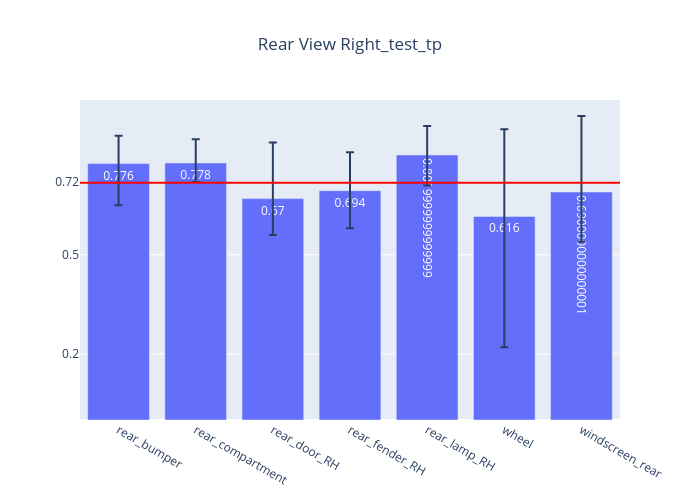

In [ ]:
#| label: Rear View Right Left TP Acc
#| fig-cap: "Rear View Right Parts TP"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_tn"
metric = metricName.split("_")[-1]
viewName = "Front View"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

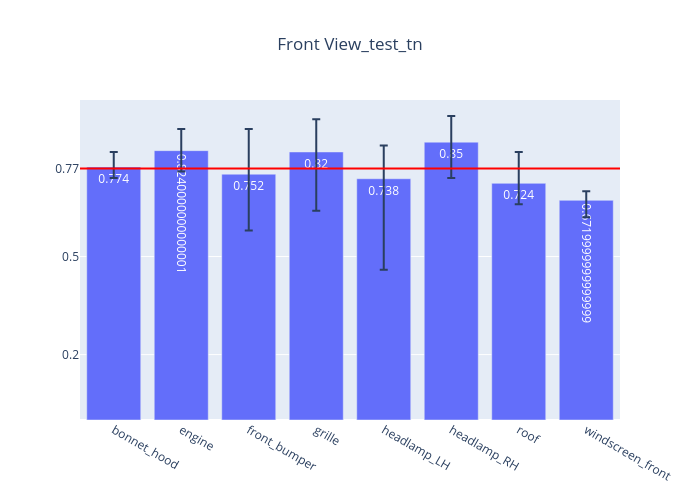

In [ ]:
#| label: Front View True Negative
#| fig-cap: "Front View Parts True Negative"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_tn"
metric = metricName.split("_")[-1]
viewName = "Front View Left"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

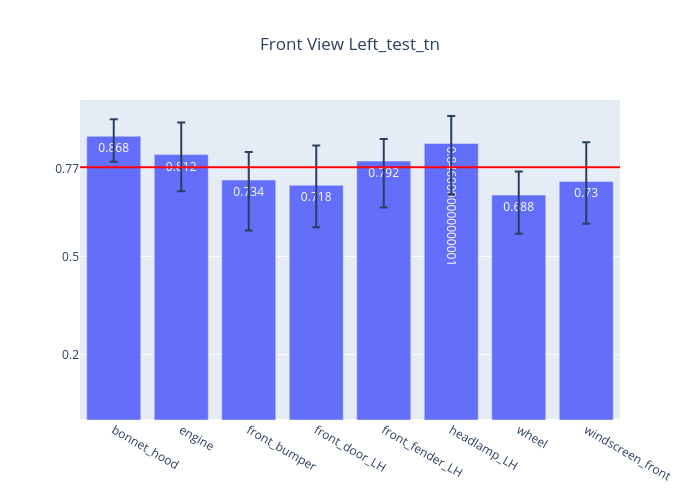

In [ ]:
#| label: Front View Left True Negative
#| fig-cap: "Front View Left Parts True Negative"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_tn"
metric = metricName.split("_")[-1]
viewName = "Front View Right"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

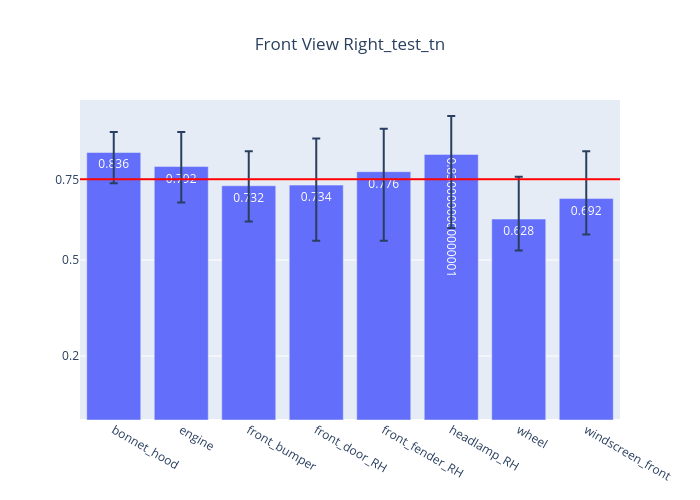

In [ ]:
#| label: Front View Right True Negative
#| fig-cap: " Front View Right Parts True Negative"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_tn"
metric = metricName.split("_")[-1]
viewName = "Rear View"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

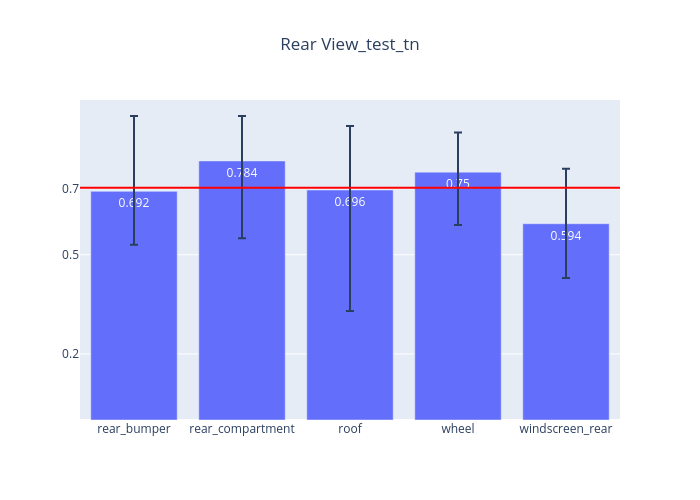

In [ ]:
#| label: Rear View True Negative
#| fig-cap: "Rear View Parts True Negative"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_tn"
metric = metricName.split("_")[-1]
viewName = "Rear View Left"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

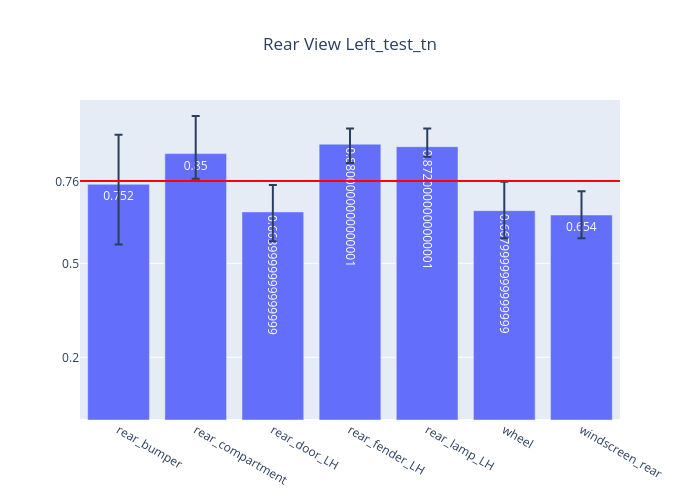

In [ ]:
#| label: Rear View Left True Negative
#| fig-cap: "Rear View Left Parts True Negative"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
metricName = "test_tn"
metric = metricName.split("_")[-1]
viewName = "Rear View Right"
df = allPerfDf[allPerfDf["view"] == viewName]
testAccDf = genAgg(df, metricName, metric)
accFig1 = vis(testAccDf, metricName, metric, viewName)
# accFig1.show()

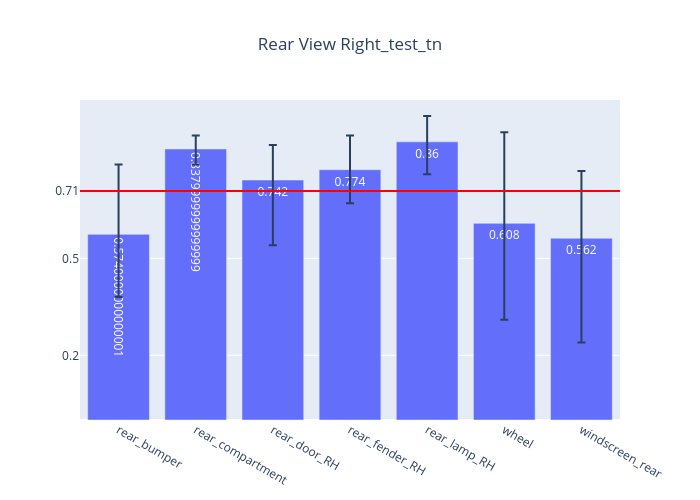

In [ ]:
#| label: Rear View Right True Negative
#| fig-cap: "Rear View Right Parts True Negative"
img_bytes = accFig1.to_image(format="png")
display.Image(img_bytes)

In [ ]:
caseEvalDf = pd.read_csv("/home/alextay96/Desktop/new_workspace/DLDataPipeline/tmp/complete_perf_by_case.csv"
                        )
avgSubsetAcc = caseEvalDf["caseAcc"].mean()
caseEvalDf["wrong_count"] = caseEvalDf["wrong_part"].apply(lambda x : len(ast.literal_eval(x)))
ThreeErrorCase = caseEvalDf[caseEvalDf["wrong_count"] <= 3]
threeCaseError = len(ThreeErrorCase) / len(caseEvalDf)
exactMatchAcc = len(caseEvalDf[caseEvalDf["wrong_count"] == 0]) / len(caseEvalDf)


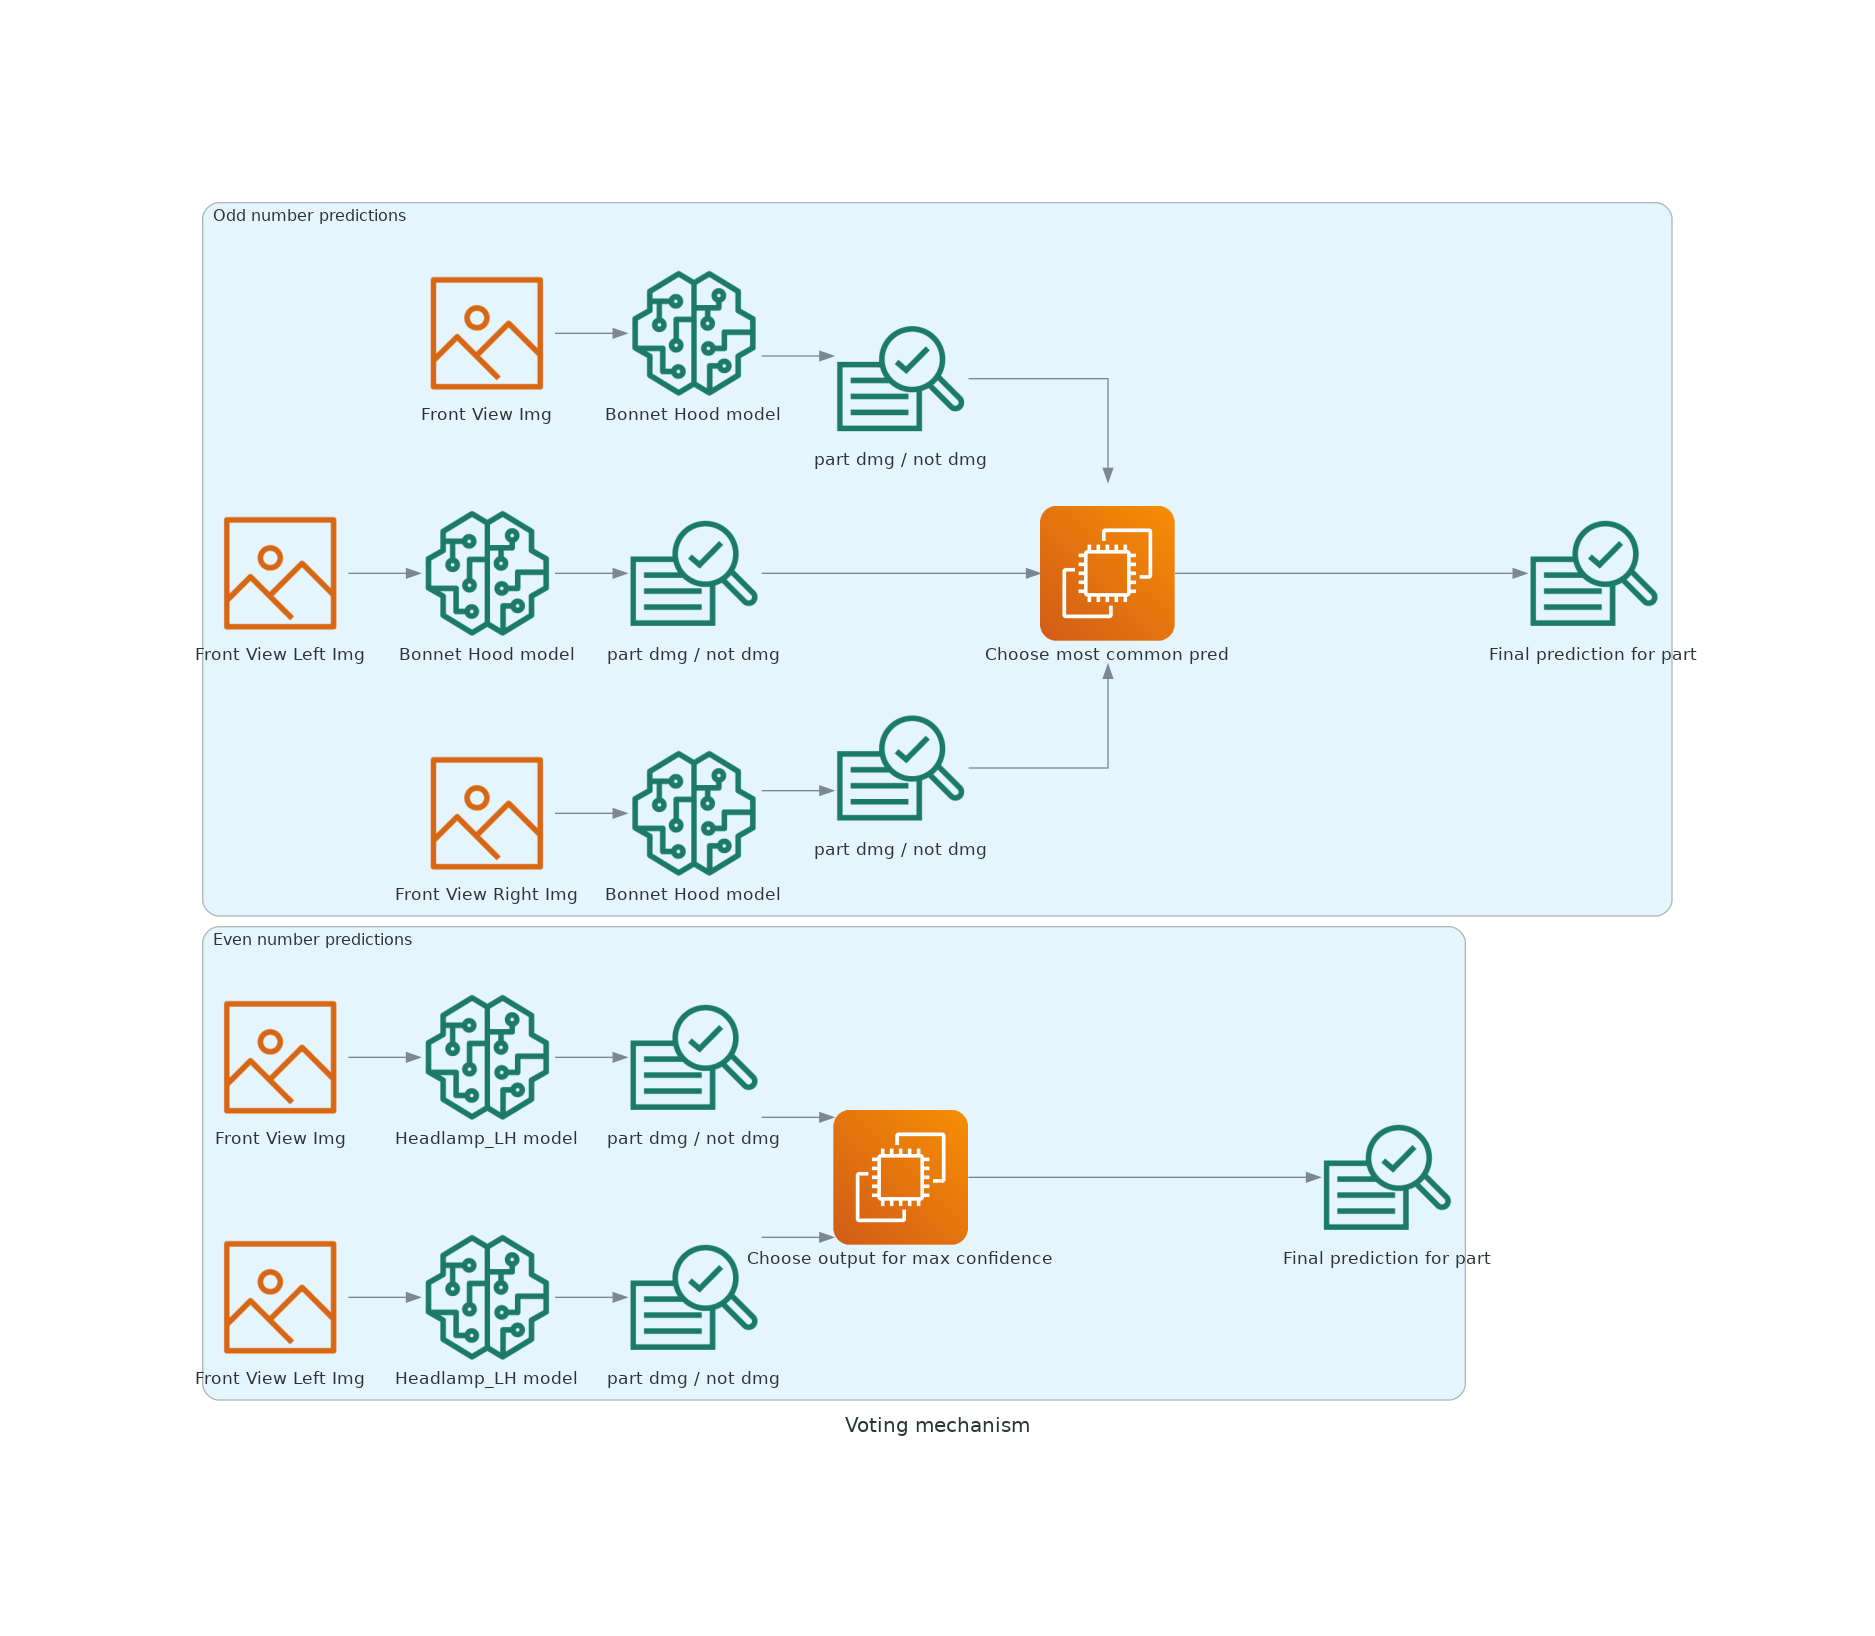

In [ ]:
from diagrams.aws.compute import EC2ContainerRegistryImage
from diagrams.aws.ml import SagemakerModel, SagemakerTrainingJob


with Diagram(name="Voting mechanism", show=False, direction="LR") as fig:
    with Cluster(label="Even number predictions") as c1:
            input1 = EC2ContainerRegistryImage(f"Front View Img") 
            m1 = SagemakerModel("Headlamp_LH model")
            o1 = SagemakerTrainingJob("part dmg / not dmg")
            input2 = EC2ContainerRegistryImage(f"Front View Left Img") 
            m2 = SagemakerModel("Headlamp_LH model")
            o2 = SagemakerTrainingJob("part dmg / not dmg")
            EnsembleSys = EC2("Choose output for max confidence")
            finalOutput = SagemakerTrainingJob("Final prediction for part")

            input1 >> m1 >> o1 >>EnsembleSys
            input2 >> m2 >> o2 >>EnsembleSys
            EnsembleSys >>Edge(minlen="3") >> finalOutput
    with Cluster(label="Odd number predictions") as c1:
            input1 = EC2ContainerRegistryImage(f"Front View Img") 
            m1 = SagemakerModel("Bonnet Hood model")
            o1 = SagemakerTrainingJob("part dmg / not dmg")
            input2 = EC2ContainerRegistryImage(f"Front View Left Img") 
            m2 = SagemakerModel("Bonnet Hood model")
            o2 = SagemakerTrainingJob("part dmg / not dmg")
            input3 = EC2ContainerRegistryImage(f"Front View Right Img") 
            m3 = SagemakerModel("Bonnet Hood model")
            o3 = SagemakerTrainingJob("part dmg / not dmg")
            EnsembleSys = EC2("Choose most common pred")
            finalOutput = SagemakerTrainingJob("Final prediction for part")

            input1 >> m1 >> o1 >>EnsembleSys
            input2 >> m2 >> o2 >>Edge(minlen="2")>>EnsembleSys
            input3 >> m3 >> o3 >>EnsembleSys

            EnsembleSys >>Edge(minlen="3") >> finalOutput

fig

In [ ]:
meanVal = caseEvalDf["caseAcc"].mean()
# medianVal = multilabelCaseDf["subset_acc"].median()
firstQuarter = np.quantile(caseEvalDf["caseAcc"].values, 0.25)
thirdQuarter = np.quantile(caseEvalDf["caseAcc"].values, 0.75)

fig = px.histogram(caseEvalDf, x="caseAcc")
fig.add_vline(x=meanVal, line_width=2, line_color="red")
# fig.add_vline(x=medianVal, line_width=2, line_color="blue")
fig.add_vline(x=firstQuarter, line_width=2, line_color="orange")
fig.add_vline(x=thirdQuarter, line_width=2, line_color="green")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [meanVal, firstQuarter, thirdQuarter],
    )
)
# fig.show()

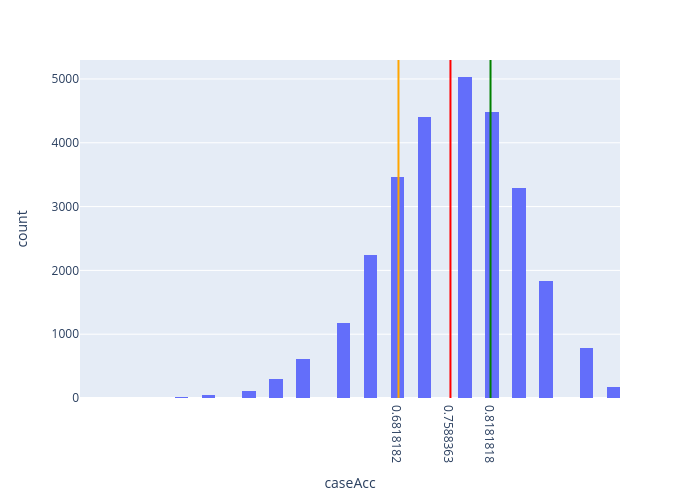

In [ ]:
#| label: Subset accuracy distribution for 1 model per part system
#| fig-cap: "Red line for mean, Green line for 75% quantile and Orange line for 25% quantile"
img_bytes = fig.to_image(format="png")
display.Image(img_bytes)

In [ ]:
fig = px.bar(x=["subset_acc", "less_than_3_item_error_acc", "exact_match_acc"], y=[avgSubsetAcc, threeCaseError, exactMatchAcc], text_auto=True)

fig.update_layout(
    title=go.layout.Title(
        text=f"Case Performance",
        x=0.5
    ))
# fig.show()

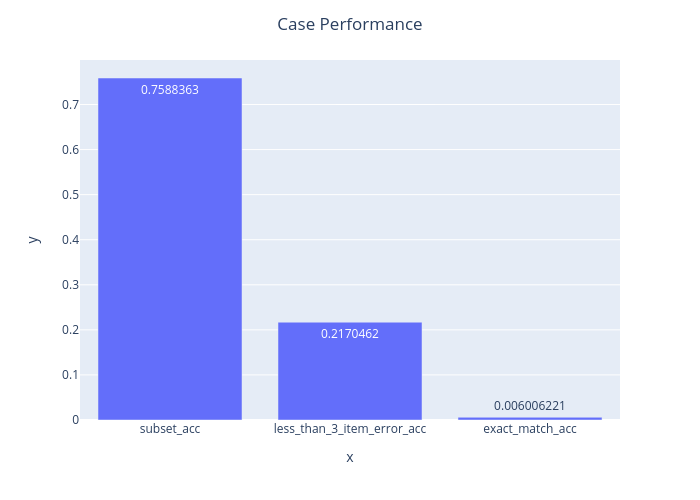

In [ ]:
#| label: Models performance per case 2   
#| fig-cap: "Subset Accuracy is around 75%"
img_bytes = fig.to_image(format="png")
display.Image(img_bytes)

In [ ]:
multilabelCaseDf = pd.read_csv("../tmp/multilabel_result.csv")


In [ ]:
meanVal = multilabelCaseDf["subset_acc"].mean()
# medianVal = multilabelCaseDf["subset_acc"].median()
firstQuarter = np.quantile(multilabelCaseDf["subset_acc"].values, 0.25)
thirdQuarter = np.quantile(multilabelCaseDf["subset_acc"].values, 0.75)

fig = px.histogram(multilabelCaseDf, x="subset_acc")
fig.add_vline(x=meanVal, line_width=2, line_color="red")
# fig.add_vline(x=medianVal, line_width=2, line_color="blue")
fig.add_vline(x=firstQuarter, line_width=2, line_color="orange")
fig.add_vline(x=thirdQuarter, line_width=2, line_color="green")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [meanVal, firstQuarter, thirdQuarter],
    )
)
# fig.show()

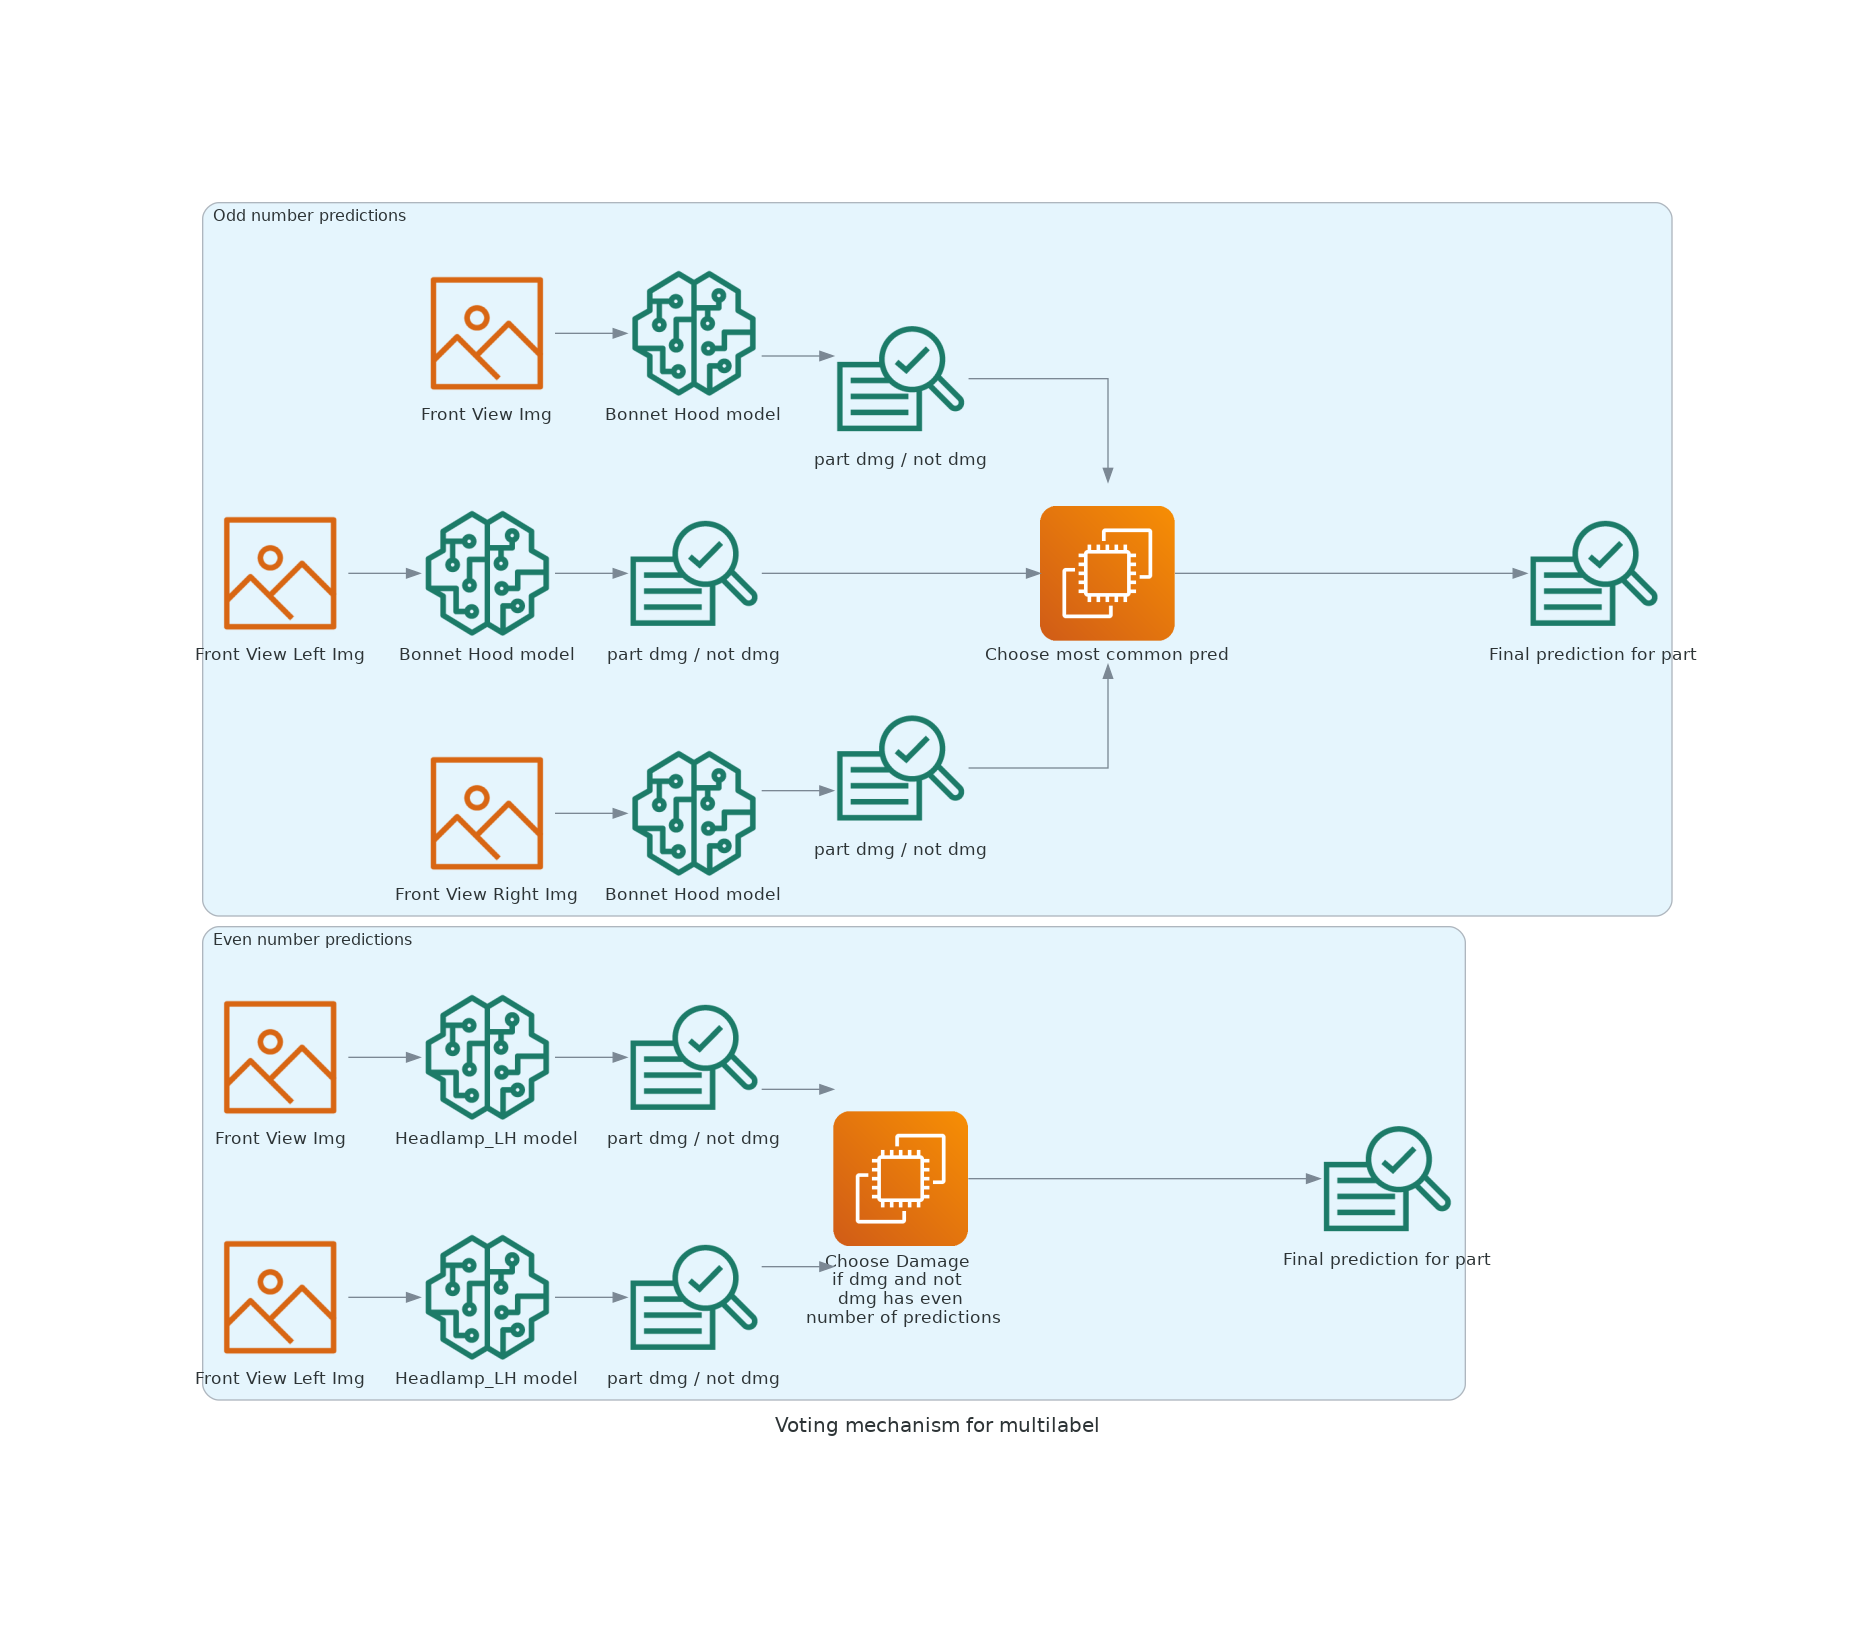

In [ ]:
from diagrams.aws.compute import EC2ContainerRegistryImage
from diagrams.aws.ml import SagemakerModel, SagemakerTrainingJob


with Diagram(name="Voting mechanism for multilabel", show=False, direction="LR") as fig:
    with Cluster(label="Even number predictions") as c1:
            input1 = EC2ContainerRegistryImage(f"Front View Img") 
            m1 = SagemakerModel("Headlamp_LH model")
            o1 = SagemakerTrainingJob("part dmg / not dmg")
            input2 = EC2ContainerRegistryImage(f"Front View Left Img") 
            m2 = SagemakerModel("Headlamp_LH model")
            o2 = SagemakerTrainingJob("part dmg / not dmg")
            EnsembleSys = EC2("Choose Damage \nif dmg and not \ndmg has even\n number of predictions")
            finalOutput = SagemakerTrainingJob("Final prediction for part")

            input1 >> m1 >> o1 >>EnsembleSys
            input2 >> m2 >> o2 >>EnsembleSys
            EnsembleSys >>Edge(minlen="3") >> finalOutput
    with Cluster(label="Odd number predictions") as c1:
            input1 = EC2ContainerRegistryImage(f"Front View Img") 
            m1 = SagemakerModel("Bonnet Hood model")
            o1 = SagemakerTrainingJob("part dmg / not dmg")
            input2 = EC2ContainerRegistryImage(f"Front View Left Img") 
            m2 = SagemakerModel("Bonnet Hood model")
            o2 = SagemakerTrainingJob("part dmg / not dmg")
            input3 = EC2ContainerRegistryImage(f"Front View Right Img") 
            m3 = SagemakerModel("Bonnet Hood model")
            o3 = SagemakerTrainingJob("part dmg / not dmg")
            EnsembleSys = EC2("Choose most common pred")
            finalOutput = SagemakerTrainingJob("Final prediction for part")

            input1 >> m1 >> o1 >>EnsembleSys
            input2 >> m2 >> o2 >>Edge(minlen="2")>>EnsembleSys
            input3 >> m3 >> o3 >>EnsembleSys

            EnsembleSys >>Edge(minlen="3") >> finalOutput

fig

In [ ]:
# #| title: Subset Accuracy distribution for multilabel system
# #| fig-cap: "Subset Accuracy is around 86%, which is a significant improvement"
# img_bytes = fig.to_image(format="png")
# display.Image(img_bytes)

In [ ]:

avgSubsetAcc = multilabelCaseDf["subset_acc"].mean()
ThreeErrorCase = multilabelCaseDf[multilabelCaseDf["correct"] >= 19]
threeCaseError = len(ThreeErrorCase) / len(multilabelCaseDf)
exactMatchAcc = len(multilabelCaseDf[multilabelCaseDf["correct"] == 22]) / len(multilabelCaseDf)

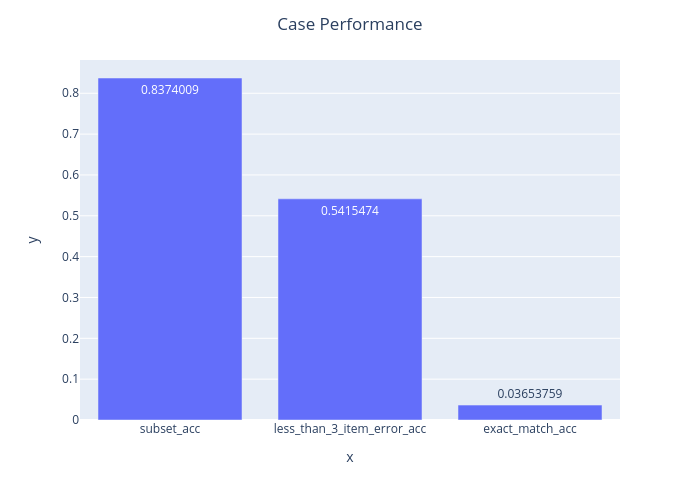

In [ ]:
fig = px.bar(x=["subset_acc", "less_than_3_item_error_acc", "exact_match_acc"], y=[avgSubsetAcc, threeCaseError, exactMatchAcc], text_auto=True)

fig.update_layout(
    title=go.layout.Title(
        text=f"Case Performance",
        x=0.5
    ))
#| label: Models performance for multilabel system
#| fig-cap: "Less than 3 item error rate increases significantly"
img_bytes = fig.to_image(format="png")
display.Image(img_bytes)
# fig.show()

In [ ]:
multilabelPartDf = pd.read_csv("/home/alextay96/Desktop/new_workspace/DLDataPipeline/tmp/multilabel_breakdown.csv")

In [ ]:
def genVisMulitlabel(multilabelPartDf, metricName):
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=multilabelPartDf["part"], y=multilabelPartDf[metricName],
        text = multilabelPartDf[metricName]
        ))
    avgVal = multilabelPartDf[metricName].mean()
    fig.add_hline(y=avgVal, line_width=2, line_color="red")
    fig.update_layout(
        yaxis = dict(
            tickmode = 'array',
            tickvals = [np.format_float_positional(avgVal, 2), 0.3, 0.8],
        )
    )
    fig.update_layout(
            title=go.layout.Title(
                text=f"{metricName}",
                x=0.5
            ))
    
    # fig.show()
    img_bytes = fig.to_image(format="png")
    return display.Image(img_bytes)

    # return fig

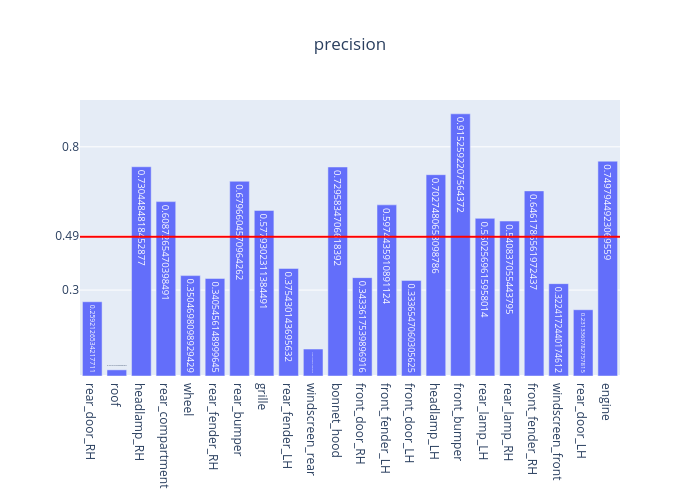

In [ ]:
#| label: Multilabel system precision
#| fig-cap: "Precision is low for multilabel system"
metric = "precision"
genVisMulitlabel(multilabelPartDf, metric)
# img_bytes = fig.to_image(format="png")
# display.Image(img_bytes)


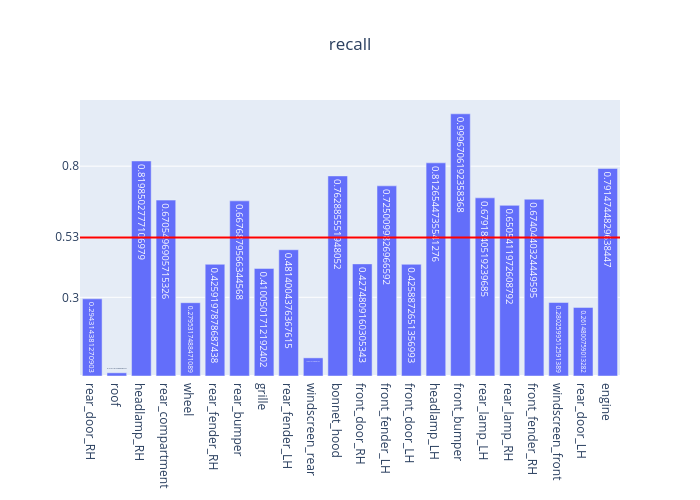

In [ ]:
#| label: Multilabel system recall
#| fig-cap: "Recall is low for multilabel system"
metric = "recall"
genVisMulitlabel(multilabelPartDf, metric)

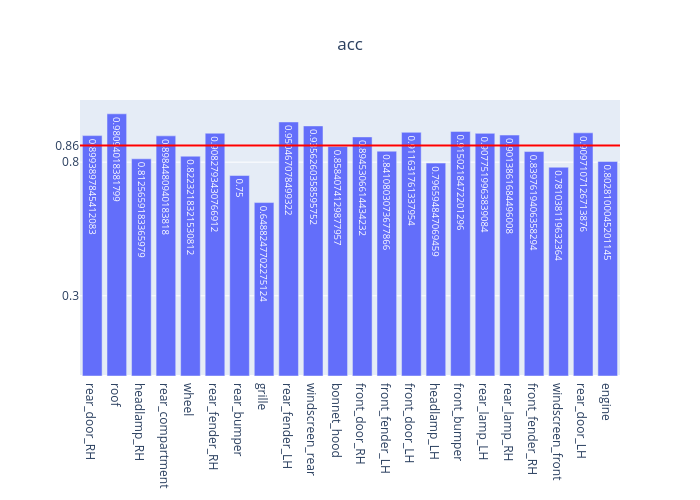

In [ ]:
#| label: Multilabel system accuracy
#| fig-cap: "Accuracy for each part"

metric = "acc"
genVisMulitlabel(multilabelPartDf, metric)

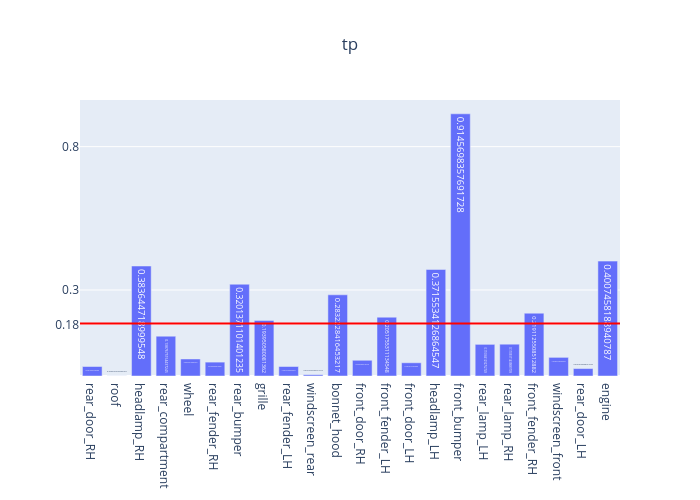

In [ ]:
#| label: Multilabel system True Positive By Parts
#| fig-cap: "TP is much worse than pervious systems due to severe label imbalance"
metric = "tp"
genVisMulitlabel(multilabelPartDf, metric)

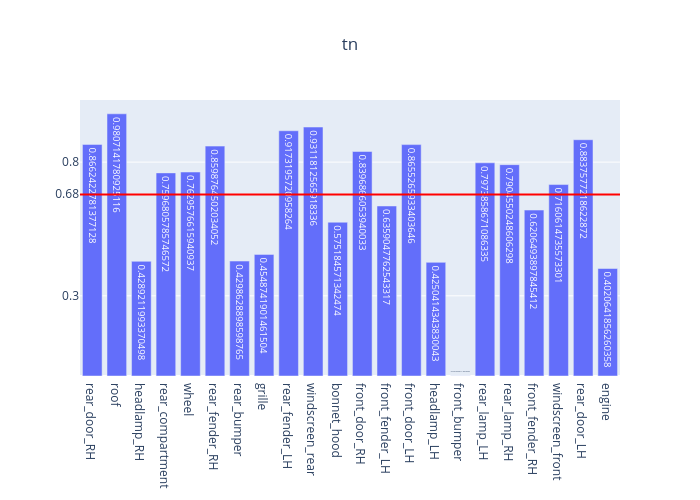

In [ ]:
#| label: Multilabel system True Negative By Parts
#| fig-cap: "TN is close to expected value"
metric = "tn"
genVisMulitlabel(multilabelPartDf, metric)

In [ ]:
multilabelPartPosWeightDf = pd.read_csv("../tmp/multilabel_breakdown_pos_weight.csv")


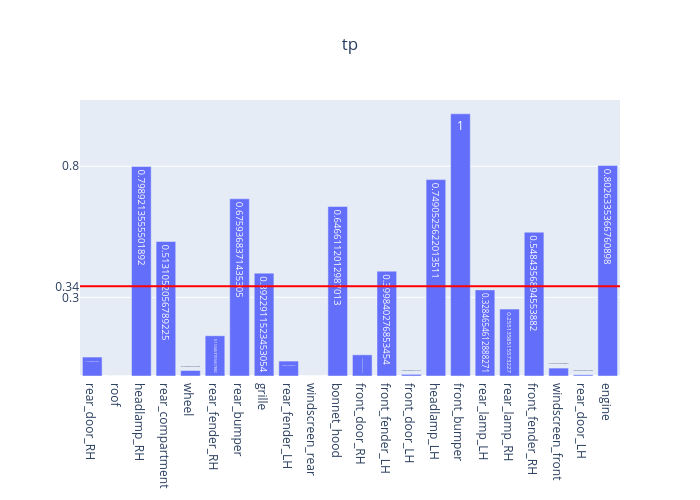

In [ ]:
#| label: Multilabel system True Positive By Parts With Positive weight
#| fig-cap: "TP is much worse than pervious systems due to severe label imbalance"
metric = "tp"
genVisMulitlabel(multilabelPartPosWeightDf, metric)

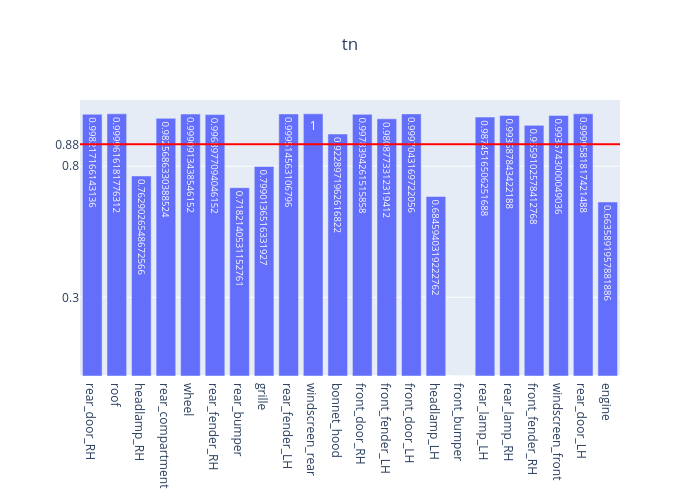

In [ ]:
#| label: Multilabel system True Negative By Parts With Positive weight
#| fig-cap: "tn"
metric = "tn"
genVisMulitlabel(multilabelPartPosWeightDf, metric)

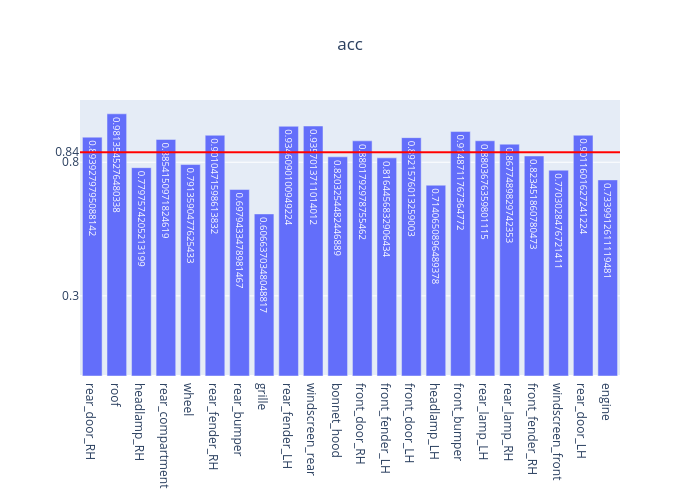

In [ ]:
#| label: Multilabel system accuracy with pos weight
#| fig-cap: "Accuracy for each part"

metric = "acc"
genVisMulitlabel(multilabelPartPosWeightDf, metric)

In [ ]:
multilabelCasePosWeightDf = pd.read_csv("../tmp/multilabel_result_pos_weight.csv")


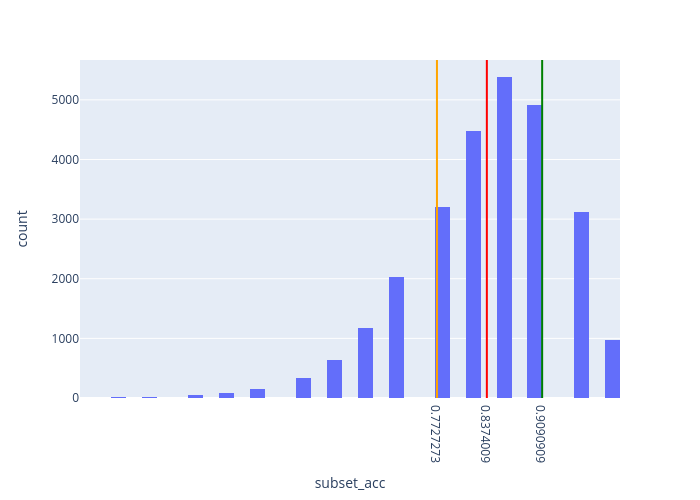

In [ ]:
#| title: Subset Accuracy distribution for multilabel system with pos weight
#| fig-cap: "Subset Accuracy is around 83%, which is slightly lower than previous system"
meanVal = multilabelCasePosWeightDf["subset_acc"].mean()
# medianVal = multilabelCaseDf["subset_acc"].median()
firstQuarter = np.quantile(multilabelCasePosWeightDf["subset_acc"].values, 0.25)
thirdQuarter = np.quantile(multilabelCasePosWeightDf["subset_acc"].values, 0.75)

fig = px.histogram(multilabelCasePosWeightDf, x="subset_acc")
fig.add_vline(x=meanVal, line_width=2, line_color="red")
# fig.add_vline(x=medianVal, line_width=2, line_color="blue")
fig.add_vline(x=firstQuarter, line_width=2, line_color="orange")
fig.add_vline(x=thirdQuarter, line_width=2, line_color="green")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [meanVal, firstQuarter, thirdQuarter],
    )
)

img_bytes = fig.to_image(format="png")
display.Image(img_bytes)

In [ ]:

avgSubsetAcc = multilabelCasePosWeightDf["subset_acc"].mean()
ThreeErrorCase = multilabelCasePosWeightDf[multilabelCasePosWeightDf["correct"] >= 19]
threeCaseError = len(ThreeErrorCase) / len(multilabelCasePosWeightDf)
exactMatchAcc = len(multilabelCasePosWeightDf[multilabelCasePosWeightDf["correct"] == 22]) / len(multilabelCasePosWeightDf)

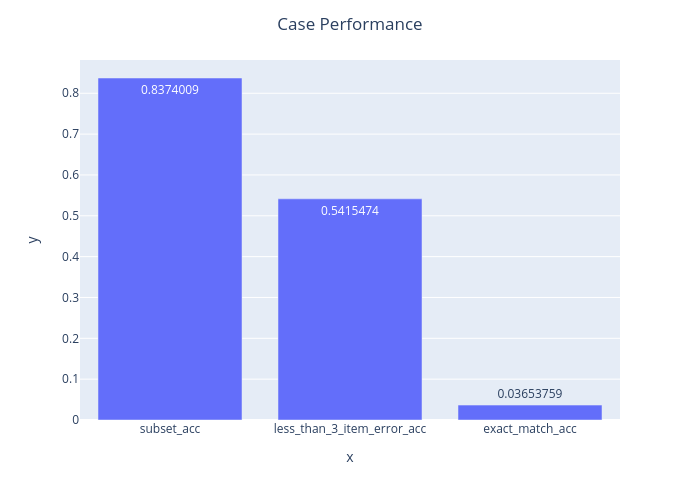

In [ ]:
fig = px.bar(x=["subset_acc", "less_than_3_item_error_acc", "exact_match_acc"], y=[avgSubsetAcc, threeCaseError, exactMatchAcc], text_auto=True)

fig.update_layout(
    title=go.layout.Title(
        text=f"Case Performance",
        x=0.5
    ))
#| label: Models performance for multilabel system
#| fig-cap: "Less than 3 item error rate increases significantly"
img_bytes = fig.to_image(format="png")
display.Image(img_bytes)

In [ ]:
multilabelCaseHighPosDf = pd.read_csv("../tmp/multilabel_result_high_pos.csv")


In [ ]:
#| title: Subset Accuracy distribution for multilabel system with pos weight
#| fig-cap: "Subset Accuracy is around 83%, which is slightly lower than previous system"
meanVal = multilabelCaseHighPosDf["subset_acc"].mean()
# medianVal = multilabelCaseDf["subset_acc"].median()
firstQuarter = np.quantile(multilabelCaseHighPosDf["subset_acc"].values, 0.25)
thirdQuarter = np.quantile(multilabelCaseHighPosDf["subset_acc"].values, 0.75)

fig = px.histogram(multilabelCaseHighPosDf, x="subset_acc")
fig.add_vline(x=meanVal, line_width=2, line_color="red")
# fig.add_vline(x=medianVal, line_width=2, line_color="blue")
fig.add_vline(x=firstQuarter, line_width=2, line_color="orange")
fig.add_vline(x=thirdQuarter, line_width=2, line_color="green")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [meanVal, firstQuarter, thirdQuarter],
    )
)

# img_bytes = fig.to_image(format="png")
# display.Image(img_bytes)

In [ ]:
multilabelPartHighPos2Df = pd.read_csv("../tmp/multilabel_breakdown_high_pos_2.csv")


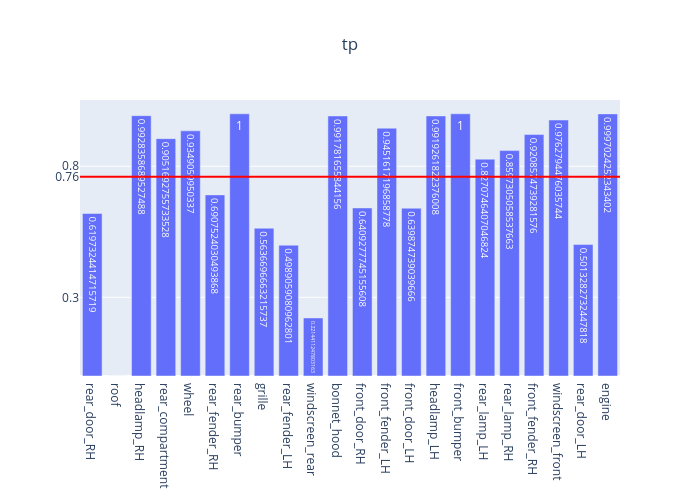

In [ ]:
metric = "tp"
genVisMulitlabel(multilabelPartHighPos2Df, metric)

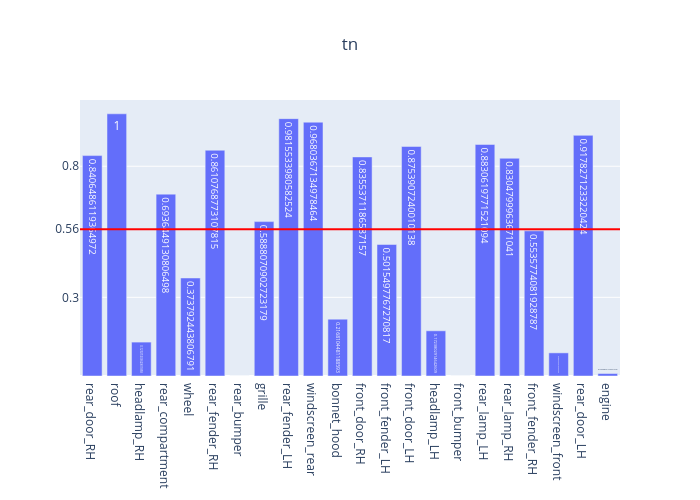

In [ ]:
metric = "tn"
genVisMulitlabel(multilabelPartHighPos2Df, metric)

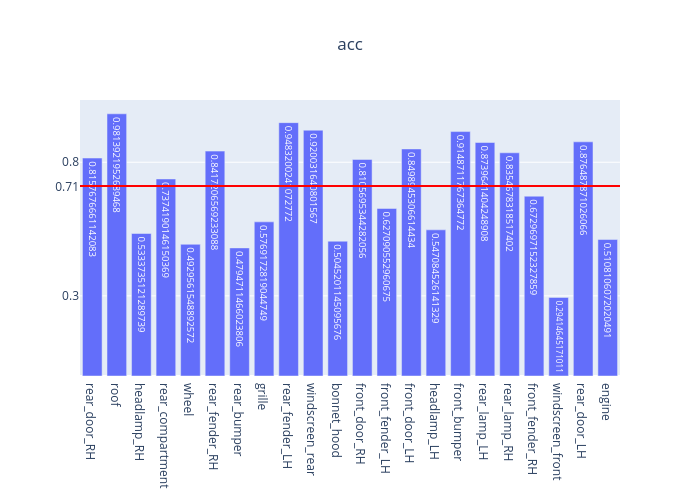

In [ ]:
metric = "acc"
genVisMulitlabel(multilabelPartHighPos2Df, metric)

In [ ]:
multilabelCaseHighPos2Df = pd.read_csv("../tmp/multilabel_result_high_pos_2.csv")


In [ ]:
meanVal = multilabelCaseHighPos2Df["subset_acc"].mean()
# medianVal = multilabelCaseDf["subset_acc"].median()
firstQuarter = np.quantile(multilabelCaseHighPos2Df["subset_acc"].values, 0.25)
thirdQuarter = np.quantile(multilabelCaseHighPos2Df["subset_acc"].values, 0.75)

fig = px.histogram(multilabelCaseHighPos2Df, x="subset_acc")
fig.add_vline(x=meanVal, line_width=2, line_color="red")
# fig.add_vline(x=medianVal, line_width=2, line_color="blue")
fig.add_vline(x=firstQuarter, line_width=2, line_color="orange")
fig.add_vline(x=thirdQuarter, line_width=2, line_color="green")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [meanVal, firstQuarter, thirdQuarter],
    )
)

In [ ]:
multilabelPartHighPos2Df = pd.read_csv("../tmp/multilabel_breakdown_focal_loss_pos.csv")


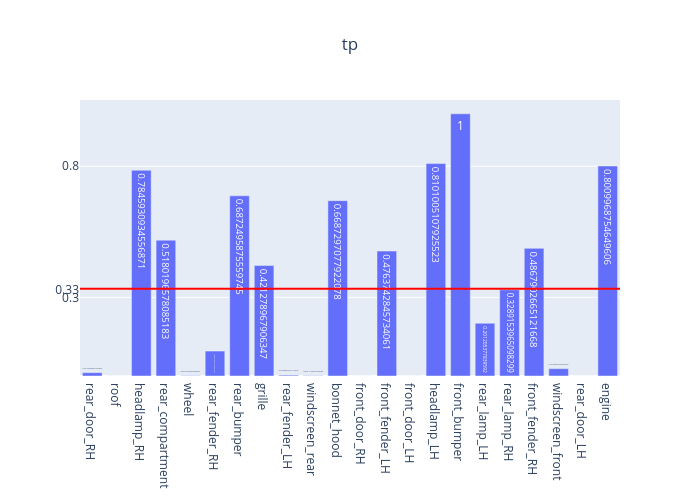

In [ ]:
metric = "tp"
genVisMulitlabel(multilabelPartHighPos2Df, metric)

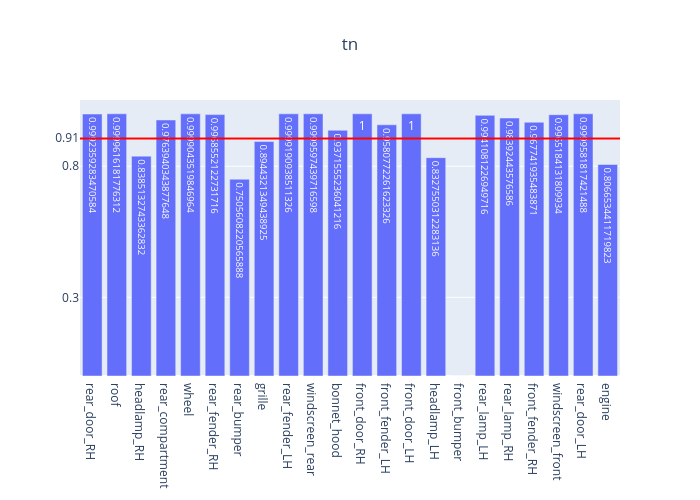

In [ ]:
metric = "tn"
genVisMulitlabel(multilabelPartHighPos2Df, metric)

In [ ]:
multilabelPartHighResDf = pd.read_csv("../tmp/multilabel_breakdown_high_resolution.csv")


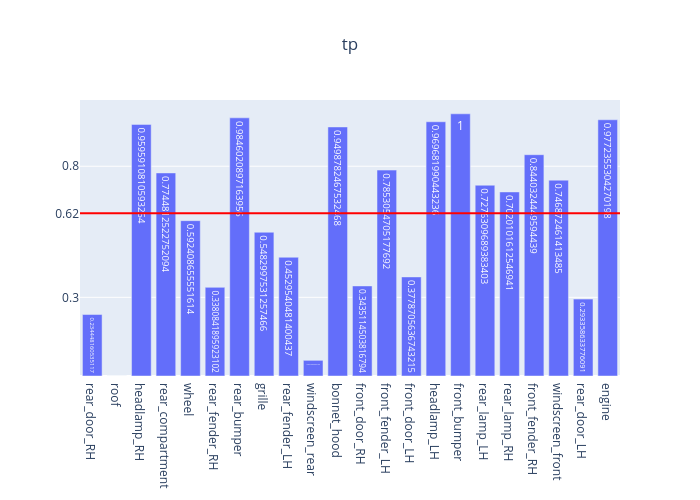

In [ ]:
metric = "tp"
genVisMulitlabel(multilabelPartHighResDf, metric)

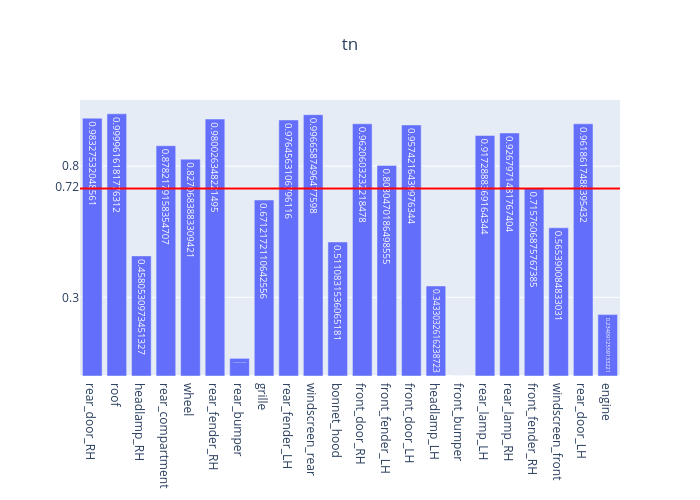

In [ ]:
metric = "tn"
genVisMulitlabel(multilabelPartHighResDf, metric)

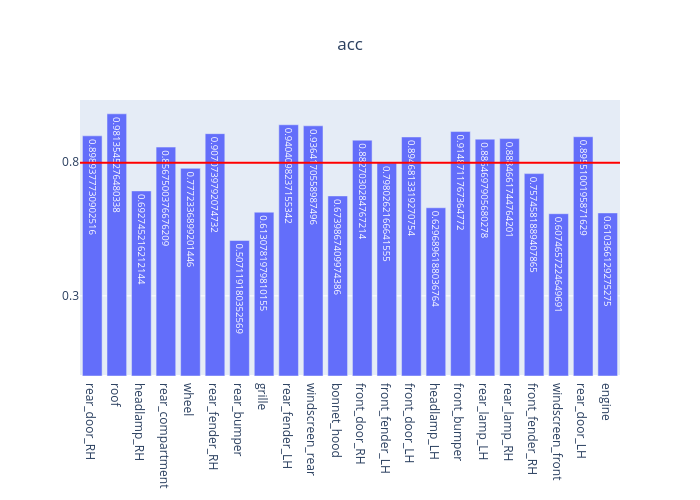

In [ ]:
metric = "acc"
genVisMulitlabel(multilabelPartHighResDf, metric)

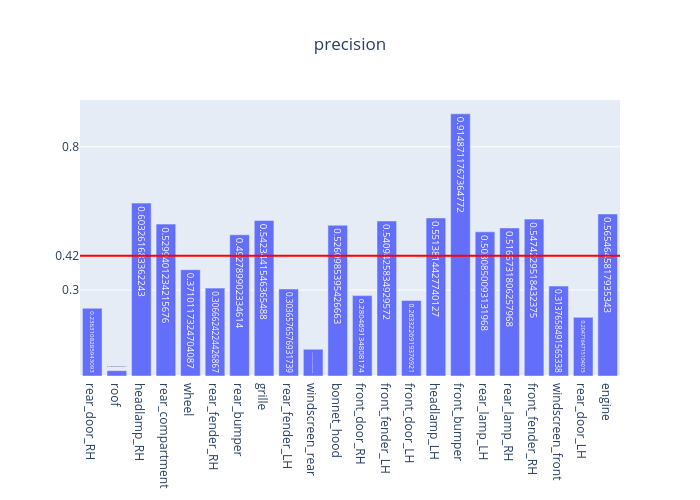

In [ ]:
metric = "precision"
genVisMulitlabel(multilabelPartHighResDf, metric)

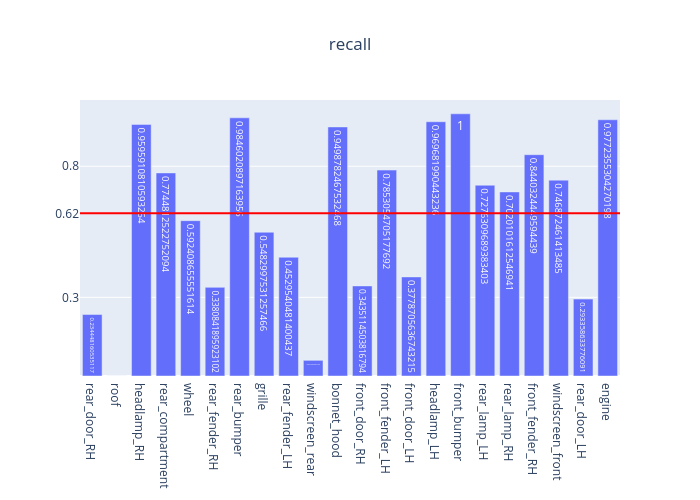

In [ ]:
metric = "recall"
genVisMulitlabel(multilabelPartHighResDf, metric)

In [ ]:
multilabelCaseHighResDf = pd.read_csv("../tmp/multilabel_result_high_resolution.csv")


In [ ]:
meanVal = multilabelCaseHighResDf["subset_acc"].mean()
# medianVal = multilabelCaseDf["subset_acc"].median()
firstQuarter = np.quantile(multilabelCaseHighResDf["subset_acc"].values, 0.25)
thirdQuarter = np.quantile(multilabelCaseHighResDf["subset_acc"].values, 0.75)

fig = px.histogram(multilabelCaseHighResDf, x="subset_acc")
fig.add_vline(x=meanVal, line_width=2, line_color="red")
# fig.add_vline(x=medianVal, line_width=2, line_color="blue")
fig.add_vline(x=firstQuarter, line_width=2, line_color="orange")
fig.add_vline(x=thirdQuarter, line_width=2, line_color="green")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [meanVal, firstQuarter, thirdQuarter],
    )
)

In [18]:
def VisDmgLabel(df:pd.DataFrame, allTargetParts:List[str], view:str, kfold : int):
    allDmgParts = []
    for p in allTargetParts:
        dmgCount = df[df[p] == 1][p].count()
        allDmgParts.append(
            {
                "part" : p,
                "dmg_count" : dmgCount,
                "dmg_ratio" : dmgCount / len(df) ,
                'view' : view,
                "kfold" : kfold,
                "model" :f"{view}_{p}"
            }
        )
    return allDmgParts


In [19]:
imgSrcDir, labelSrcDir = GetDataDir()
allParts = getAllPart()
inputDir = labelSrcDir
searchImgView = f"{inputDir}/*.csv"
allSrcAnnFile = glob.glob(searchImgView, recursive=True)
allBalanceMetrics = []
allMultilearnMetrics = []
allGtBalanceMetrics = []
for srcAnnPath in tqdm(allSrcAnnFile, desc="view"):
    imgAngle = srcAnnPath.split("/")[-1].split("_")[1]
    trainParams.srcAnnFile = srcAnnPath
    trainParams.imgAngle = imgAngle
    srcDf = pd.read_csv(trainParams.srcAnnFile)

    allTargetParts = [x for x in srcDf.columns if x in allParts]
    trainParams.runName = imgAngle
    trainParams.targetPart = allTargetParts
    mulitlearnStratify = MultilabelStratifiedKFold(
        n_splits=2,shuffle=True
    )
    skf = KFold(n_splits=2)
    targetPart = trainParams.targetPart
    # srcDf2 = BalanceSampling(srcDf, allTargetParts)
    y = srcDf[allTargetParts]
    X = srcDf["Path"]
    gtLabelDf = VisDmgLabel(y, allTargetParts, view=imgAngle,kfold=0)
    allGtBalanceMetrics.extend(gtLabelDf)
    allSplit = []
    allPreds = []
    for kfoldId, (train_index, test_index) in enumerate(
        skf.split(X, y)
    ):

        # X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        balanceMetrics = VisDmgLabel(y_test, allTargetParts, view=imgAngle,kfold=kfoldId)
        allBalanceMetrics.extend(balanceMetrics)
    for kfoldId, (train_index, test_index) in enumerate(
        mulitlearnStratify.split(X, y)
    ):

        # X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        balanceMetrics = VisDmgLabel(y_test, allTargetParts, view=imgAngle,kfold=kfoldId)
        allMultilearnMetrics.extend(balanceMetrics)
kfoldBalanceDf = pd.json_normalize(allBalanceMetrics)
kfoldBalanceDf = kfoldBalanceDf[kfoldBalanceDf["kfold"] == 0]
MultilearnKfoldBalanceDf = pd.json_normalize(allMultilearnMetrics)
MultilearnKfoldBalanceDf = MultilearnKfoldBalanceDf[MultilearnKfoldBalanceDf["kfold"] == 0]
gtKfoldBalanceDf = pd.json_normalize(allGtBalanceMetrics)
gtKfoldBalanceDf = gtKfoldBalanceDf[gtKfoldBalanceDf["kfold"] == 0]


view: 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


In [20]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=gtKfoldBalanceDf["model"], y=gtKfoldBalanceDf["dmg_ratio"],
    text = gtKfoldBalanceDf["dmg_ratio"],
    
))
avgVal = gtKfoldBalanceDf["dmg_ratio"].mean()
fig.add_hline(y=avgVal, line_width=2, line_color="red")
    # print(avgVal)
fig.update_layout(
    title="Ground Truth Positive Damage Distribution",

    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgVal, 2), 0.2, 0.5, 0.7],
    )
)

fig

In [21]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=kfoldBalanceDf["model"], y=kfoldBalanceDf["dmg_ratio"],
    text = kfoldBalanceDf["dmg_ratio"],
    
))
avgVal = kfoldBalanceDf["dmg_ratio"].mean()
fig.add_hline(y=avgVal, line_width=2, line_color="red")
    # print(avgVal)
fig.update_layout(
    title="Scikit K Fold Eval Set Positive Damage Distribution",

    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgVal, 2), 0.2, 0.5, 0.7],
    )
)

fig

In [22]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=MultilearnKfoldBalanceDf["model"], y=MultilearnKfoldBalanceDf["dmg_ratio"],
    text = MultilearnKfoldBalanceDf["dmg_ratio"],
    
))
avgVal = MultilearnKfoldBalanceDf["dmg_ratio"].mean()
fig.add_hline(y=avgVal, line_width=2, line_color="red")
    # print(avgVal)
fig.update_layout(
    title="Specialised Multilabel Stratification Algo Positive Damage Distribution",

    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgVal, 2), 0.2, 0.5, 0.7],
    )
)

fig

# 3 Very Important Questions
## 1. Do we need to support all parts from all part group ? i.e. Undercarriage / Interior
## 2. Do we need to support parts from all cost ? Sticker < RM 50
## 3. Do we need to support all circumstances of accident ? i.e. Non collision circumstances 
### flood + fire > RM 50